In [ ]:
# !conda install --yes --prefix {sys.prefix} scikit-image
# !pip3 install scikit-image

In [34]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data
from skimage import io, transform
from skimage.measure import block_reduce
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
def get_photo_file(photo_name):
    return "data/yelp_photos/photos/" + photo_name + ".jpg"

def resize_img(img):
    return transform.resize(img, (224, 224))

In [35]:
class YelpDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, batch_size, shuffle=True):
        self.df = df 
        self.batch_size = batch_size
        if shuffle:
            self.df = self.df.sample(frac=1)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        photo_names = self.df.iloc[idx:idx+self.batch_size].index.tolist()
        file_names = [get_photo_file(photo_name) for photo_name in photo_names]
        images = [io.imread(file_name) for file_name in file_names]
        images = [resize_img(img) for img in images] 
        label = self.df.iloc[idx:idx+self.batch_size].label.tolist()
        return (torch.Tensor(images),torch.Tensor(label))

In [14]:
biz_df = pd.read_csv("data/clean_business.csv").set_index("business_id")
photo_df = pd.read_csv("data/clean_photo.csv").set_index("photo_id")
df = photo_df.copy(deep=True)
df["label"] = pd.Series(biz_df.loc[df["business_id"]]["stars"]).tolist()
df = df.sample(frac=1)

# train_df = df.iloc[0:int(len(df) * 0.7)]
# val_df = df.iloc[int(len(df) * 0.7):]

val_df = df.iloc[0:1000]
train_df = df.iloc[1000:11000]

In [16]:
train_loader = YelpDataset(train_df, batch_size=32)
val_loader = YelpDataset(val_df, batch_size=len(val_df))

In [8]:
val_img, val_label = val_loader[0]

/usr/local/opt/python3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [85]:
class BasicNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(BasicNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.fc1 = nn.Linear(28090, 100)
        self.fc2 = nn.Linear(100, 1)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = x.permute(0, 3, 1, 2)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 28090)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc2(x)
        return x

In [86]:
model = BasicNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [87]:
def train_step(step):
    

    model.train()

    input_batch, label_batch = train_loader[step]
    input_batch = Variable(input_batch)
    label_batch = Variable(label_batch)
    output_batch = model(input_batch)

    loss = F.mse_loss(output_batch, label_batch)
    #   _, pred_batch = torch.max(output_batch, dim=1)
    #   error_rate = 1.0 - (pred_batch == label_batch).float().mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  
#     return loss.data[0], error_rate.data[0]
    return loss.data[0]

In [ ]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
for module in model.children():
    module.reset_parameters()

info = []
num_steps = 100
for step in range(num_steps):
    train_loss = train_step(step)
    print(train_loss)
    info.append(train_loss)

/usr/local/opt/python3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


15.842938423156738


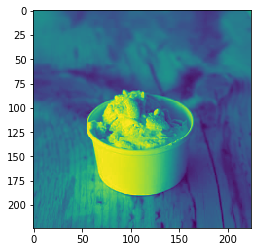

In [55]:
plt.imshow(val_img[0].permute(2, 0, 1)[0])

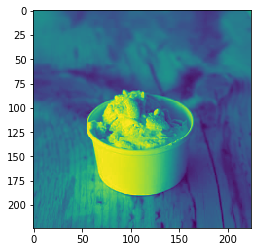

In [54]:
plt.imshow(val_img[0][:,:,0])

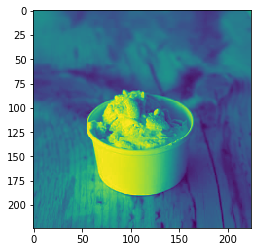

In [58]:
plt.imshow(val_img.permute(0, 3, 1, 2)[0][0])